<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

fatal: destination path 'MADSmilestone2' already exists and is not an empty directory.
/content/MADSmilestone2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
from PIL import Image
import ast
import Images
from tqdm import tqdm

In [ ]:
#!rm -rf /content/MADSmilestone2

In [4]:
# Read round, id, label dictionary file

cust_file = open("Data/customLabelDict.txt", "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionary = ast.literal_eval(contents)
cust_file.close()

In [8]:
# This portion is part of my test code
byteImgIO = io.BytesIO()
byteImg = Image.open('https://test-bucket-clockids-aicrowd.s3.us-west-1.amazonaws.com/1_10000003.tif')
byteImg.save(byteImgIO, "tif")
byteImgIO.seek(0)
byteImg = byteImgIO.read()


# Non test code
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

FileNotFoundError: ignored

In [95]:
def get_images_test(id_rounds):
    counter = 0
    store_images = []
    #image_data = []
    label_arr = []

    for id, array in tqdm(id_rounds.items()):
        for value in array:
            if counter < 40:
                url = 'https://clockimages.s3.us-west-1.amazonaws.com/NHATS_R' + str(
                    id) + '_ClockDrawings/' + value[0] + '.tif'
                #url = 'https://test-bucket-clockids-aicrowd.s3.us-west-1.amazonaws.com/1_'+ value[0] + '.tif'
                # Open files and convert to work with Image in PIL
                response = requests.get(url)  # , stream = True)
                f = io.BytesIO(response.content)
                im_pil = Image.open(f)

                # Resize pil image files
                #resized = im_pil.resize((im_pil.width // 9, im_pil.height // 9))
                resized = im_pil.resize((284,368))
                imarray1 = np.array(resized)

                #imarray = np.logical_not(np.array(im)).astype(int) #bool to int, inverts values
                #image_data.append(get_coordinates(imarray1))  # , imarray1.shape[0], imarray1.shape[1]))

                #Store the np array images into a list
                store_images.append(imarray1)

                #print("round: ", id)

                #Visualize the resized images
                #viz_image(imarray1, resized, value[0], value[1])
                
                # Store corresponding labels
                label_arr.append(value[1])
                
                counter += 1

    return store_images, label_arr




def viz_image(image, resized, value0, value1):
  print("shape: ", image.shape)
  print("spid: ", value0)
  print("label: ", value1)

  # revert
  im2 = Image.fromarray(np.array(resized))
  plt.imshow(im2)
  plt.show()

In [96]:
x, y = get_images_test(dictionary)

100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


In [101]:
X = np.array(x)
X.shape





(40, 368, 284)

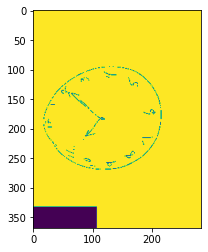

In [104]:
plt.imshow(X[10])

In [109]:
# split into train and val
ratio_val = 0.1
ratio_test = 0.1

# Get Train and Test split
X_split, X_test, y_split, y_test = train_test_split(X, y, test_size = ratio_test, random_state = 6) 

# Adjust remaining ratio for even split
ratio_remaining = 1 - ratio_test #.11111
ratio_val_ad = ratio_val / ratio_remaining 

# Get Train and Val split
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, test_size = ratio_val_ad, random_state = 6)

#Final Variables:
X_train
X_val
X_test
#----
y_train
y_val
y_test

[2, 2, 0, 2]

In [110]:
# Create classes for training data, test data 
# So far using one batch

class Helper():
  
  def __init__(self):
    self.i = 0

    # create batches  
    #self.train_batch = [#split X_train into batches]
    #self.val_batch = [#validation batch]
    #self.test_batch = [#test batch]

    self.training_images = None
    self.training_labels = None

    self.val_images = None
    self.val_labels = None

    self.test_images = None
    self.test_labels = None
  

  def get_images(self):

    print("set up images for training, val, test")

    self.training_images = np.array(self.training_images)
    train_len = len(self.training_images)

    self.val_images = np.array(self.val_images)
    val_len = len(self.val_images)

    self.test_images = np.array(self.test_images)
    test_len = len(self.test_images)



  def next_batch(self, batch_size):
    x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,368, 284) #resize to length of batch
    y = self.training_labels[self.i:self.i+batch_size]
    self.i = (self.i + batch_size) % len(self.training_images)
    return x , y 
